Verify the imports
NOTE: Please do NOT edit this panel! 

In [1]:
print('* Verifying the packages')
# System packages 
import os
import pathlib 
import sys 
import warnings
warnings.filterwarnings('ignore') # Ignore all the warnings 

# Path hidpy
sys.path.append('%s/../' % os.getcwd())

# Internal packages 
from core import file_utils
from core import optical_flow
from core import video_processing
from core import plotting
from core import msd
from core import inference

print('\t* All required packages were successfully imported!')

* Verifying the packages
	* All required packages were successfully imported!


In [2]:
############ INPUTS PANEL, YOU CAN EDIT THIS PANEL ############ 
# Input video sequence (single sequence)   
#video_sequence = '%s/../data/microscopes/h2b/u2os-h2bgfp-serum-3.avi' % os.getcwd() # parameters of this sequence: pixel_size=0.088, dt=0.200
video_sequence = '%s/../data/microscopes/dna/3.avi' % os.getcwd()                    # parameters of this sequence: pixel_size=0.065, dt=0.200

# Pixel threshold
pixel_threshold = 125

# Pixel size (should be in microns)
pixel_size = 0.065 

# Time step (should be in seconds)
dt = 0.200 

# Output directory 
root_output_directory = '%s/../output2/' % os.getcwd()
############ INPUTS PANEL, YOU CAN EDIT THIS PANEL ############ 

In [3]:
################# PLEASE DON'T EDIT THIS PANEL #################
# Verify the input parameters, and return the path where the output data will be written  
output_directory = file_utils.veryify_input_options(
    video_sequence=video_sequence, output_directory=root_output_directory, 
    pixel_threshold=pixel_threshold, pixel_size=pixel_size, dt=dt)

# Load the frames from the video 
print('* Loading frames')
frames = video_processing.get_frames_list_from_video(
    video_path=video_sequence, verbose=True)
print('\t* Frames loaded!')
################# PLEASE DON'T EDIT THIS PANEL #################

NOTE: The output path [c:\Users\valad\Documents\GitHub\hidpy\notebooks/../output2/] exists
* Loading frames
c:\Users\valad\Documents\GitHub\hidpy\notebooks/../data/microscopes/dna/3.avi
	* Video Details: 
  	* Name: c:\Users\valad\Documents\GitHub\hidpy\notebooks/../data/microscopes/dna/3.avi 
  	* Number Frames 150  	* FPS: 1.000000


100%|██████████████████████████████████████████████████| 150/150 [00:00<00:00, 156.41it/s]

	* Frames loaded!


In [4]:
################# PLEASE DON'T EDIT THIS PANEL #################
# Compute the optical flow
print('* Computing optical flow') 
u, v = optical_flow.compute_optical_flow_farneback(frames=frames)
print('\t* Optical flow computed!\n') 

# Interpolate the flow field
print('* Computing interpolations')
u, v = optical_flow.interpolate_flow_fields(u_arrays=u, v_arrays=v)
print('\t* Interpolations computed!\n')

# Compute the trajectories 
print('* Creating trajectories')
trajectories = optical_flow.compute_trajectories(
    frame=frames[0], fu_arrays=u, fv_arrays=v, pixel_threshold=pixel_threshold)
print('\t* Trajectories created!\n')

# Plot the trajectories 
print('* Plotting trajectories')
plotting.plot_trajectories_on_frame(
    frame=frames[0], trajectories=trajectories, 
    output_path='%s/trajectories' % output_directory)
print('\t* Trajectories rendered!\n')

################## PLEASE DON'T EDIT THIS PANEL #################

* Computing optical flow


100%|██████████████████████████████████████████████████| 149/149 [00:05<00:00, 26.38it/s]


Optical flow time 5.651355
	* Optical flow computed!

* Computing interpolations


100%|██████████████████████████████████████████████████| 149/149 [00:02<00:00, 52.11it/s]


	* Interpolations computed!

* Creating trajectories


100%|██████████████████████████████████████████████████| 340/340 [06:04<00:00,  1.07s/it]


	* Trajectories created!

* Plotting trajectories
	* Trajectories rendered!



In [6]:
# Calculation of the MSD (mean square displacement)

# Construct trajectory map
print('* Converting the trajectories to maps')
xp, yp = msd.convert_trajectories_to_map(trajectories, (len(frames), frames[0].shape[0], frames[0].shape[1]))

# Convert displacement to microns
xp_um=xp*pixel_size
yp_um=yp*pixel_size

# extract nucleoli mask
print('* Extracting the nucleoli map')
mask_nucleoli = msd.extract_nucleoli_map(xp_um, yp_um)

# Compute the MSDs
print('* Computing the MSDs')
MSD = msd.calculate_msd_for_every_pixel(xp_um, yp_um, mask_nucleoli)

# Baysian fit on MSDs
print('* Fitting the MSDs models using Bayesian inference')

### THIS SHOULD BE SELECTED FROM THE CONFIG FILE 
models_selected = ['D','DA','V','DV','DAV'] 

# THE TIME STEP SHOULD BE SET IN THE CONFIG GILE 
dT = dt
Bayes = inference.apply_bayesian_inference(MSD, dT, models_selected)

* Converting the trajectories to maps
* Extracting the nucleoli map
* Computing the MSDs
* Fitting the MSDs models using Bayesian inference
Bayesian inference..
Using # cores:8


100%|██████████| 46017/46017 [03:26<00:00, 222.57it/s]


Text(0.5, 1.0, 'Drift velocity [$\\mu$m/s]')

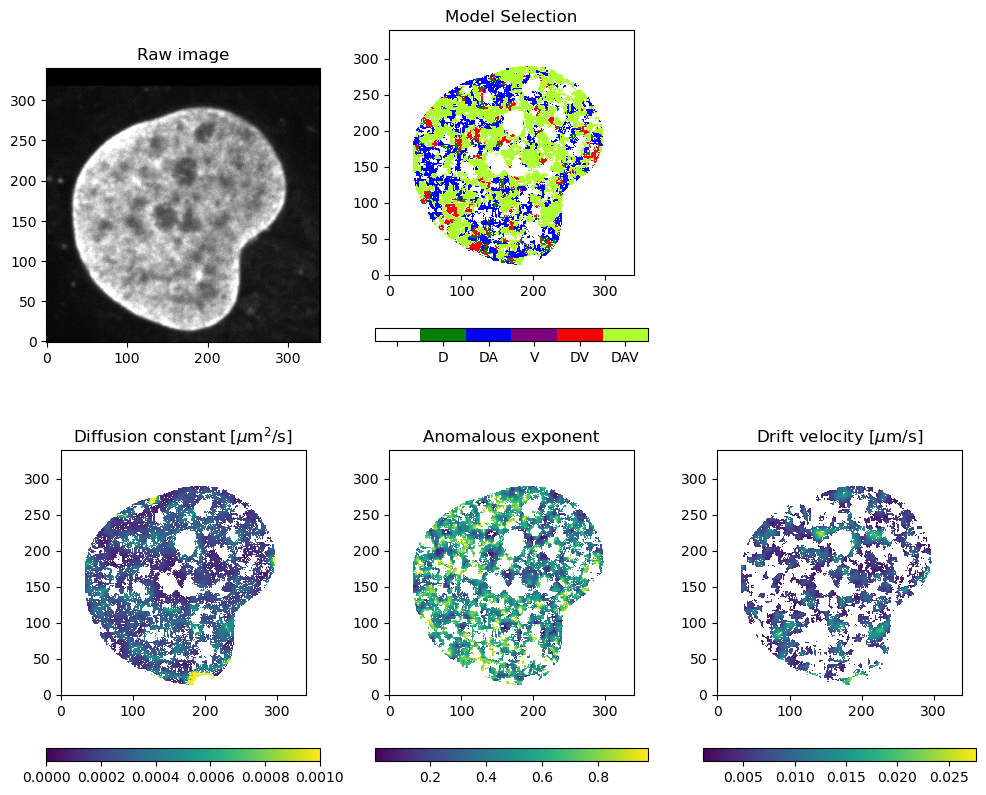

In [21]:
from pylab import *
from matplotlib import colors

matrix1=np.zeros((frames[0].shape[0],frames[0].shape[1]))
matrix1[np.where(mask_nucleoli==1)]=100

bounds = [0.5, 1.5, 2.5, 3.5, 4.5]

fig,ax=plt.subplots(2,3,figsize=[12,10])
ax[0,2].axis('off')

img0=ax[0,0].imshow(frames[0],origin='lower',cmap='gray')
ax[0,0].set_title('Raw image')

cmap = colors.ListedColormap(['w','g','b','purple','r','greenyellow'])
img1=ax[0,1].imshow(Bayes['model'], interpolation='nearest',cmap=cmap,origin='lower')
ax[0,1].contour(matrix1, colors='k', origin='lower')

cbar=fig.colorbar(img1,ax=ax[0,1],spacing='proportional',orientation='horizontal',boundaries=[-0.5] + bounds + [5.5])
labels = np.arange(0, 6, 1)
loc = labels
cbar.set_ticks(loc)
cbar.set_ticklabels([' ','D','DA','V','DV','DAV'])
ax[0,1].set_title('Model Selection')

matD=[]
matD=Bayes['D']
matD[np.where(Bayes['model']==0)]=np.nan
matD[np.where(Bayes['D']<1e-10)]=np.nan

# #figure(2)
img2=ax[1,0].imshow(matD, interpolation='nearest',cmap='viridis',origin='lower')
ax[1,0].contour(matrix1, colors='k', origin='lower')
cbarD=fig.colorbar(img2,ax=ax[1,0],spacing='proportional',orientation='horizontal')
ax[1,0].set_title(r'Diffusion constant [$\mu$m$^2$/s]')
img2.set_clim(0,0.001) # adapt colorbar limits based on data

matA=[]
matA=Bayes['A']
matA[np.where(Bayes['model']==0)]=np.nan
matA[np.where(Bayes['A']<1e-10)]=np.nan

# #figure(3)
img3=ax[1,1].imshow(matA, interpolation='nearest',cmap='viridis',origin='lower')
ax[1,1].contour(matrix1, colors='k', origin='lower')
fig.colorbar(img3,ax=ax[1,1],spacing='proportional',orientation='horizontal')
ax[1,1].set_title('Anomalous exponent')

matV=[]
matV=Bayes['V']
matV[np.where(Bayes['model']==0)]=np.nan
matV[np.where(Bayes['V']==0)]=np.nan

# #figure(4)
img4=ax[1,2].imshow(matV, interpolation='nearest',cmap='viridis',origin='lower')
ax[1,2].contour(matrix1, colors='k', origin='lower')
fig.colorbar(img4,ax=ax[1,2],spacing='proportional',orientation='horizontal')
ax[1,2].set_title(r'Drift velocity [$\mu$m/s]')



In [13]:
# Save pickle file per cell

import pickle

output_b = output_directory + "/" + "ex"
os.mkdir(output_b)

with open('%s/Results_Bayes_04102022_Cell01.pickle' % output_b, 'wb') as f:
    pickle.dump(Bayes, f)